# Pitch Detection Data

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time

In [153]:
all_ = pd.read_csv('UVA_locations.csv')
# convert the width and height to integers representing the pixel number
all_['w'] = (all_['w']*1280).astype(int)
all_['h'] = (all_['h']*720).astype(int)
all_.head()

,Frame,Label,cx,cy,w,h
0,1,plate,528,331,63,12
1,2,plate,528,331,63,12
2,3,plate,528,331,63,12
3,4,plate,528,331,63,12
4,5,plate,528,331,64,12


In [154]:
o = all_.loc[all_['Label'] != 'plate']

cnt = o.groupby(['Frame']).count()

In [155]:
# Get information on the number of times when the ball is in the image
last_frame = 0
count = 0
for frame_num in cnt.index:
    
    if abs(last_frame - frame_num) != 1:
        count += 1
        
    last_frame = frame_num

print("Number of consecutive Streams with the ball:", count )

Number of consecutive Streams with the ball: 1965


## Get the Average spot of the ball

In [157]:
# Read a basic image from the game
img = cv2.imread('frames/frame00065.jpg')
# obtain the mean x,y,width, and height values
cx = o.mean()[1]
cy = o.mean()[2]
width = o.mean()[3]
height = o.mean()[4]
# image dimensions: (720, 1280)

# top left and right of the average rectangle
start = (int(cx - (width / 2)), int(cy - (height / 2)))
end = (int(cx + (width / 2)), int(cy + (height / 2)))
# draw avg rectangle over image and save it
img = cv2.rectangle(img, start, end, (255, 0, 255) , 2)
cv2.imwrite("Average_spot.png", img)

True

## Heatmap of Ball Locations

In [146]:
locations = o[['cx','cy']]
locations

,cx,cy
5,431,333
7,431,332
8,420,326
10,431,332
11,421,327
13,429,334
14,420,329
16,430,335
17,421,329
19,431,334


"\nheatmap, xedges, yedges = np.histogram2d(x, y, bins=(160,90))\nextent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]\n\nplt.clf()\nplt.imshow(heatmap.T, extent=extent, origin='lower')\nplt.colorbar()\nplt.show()\n"

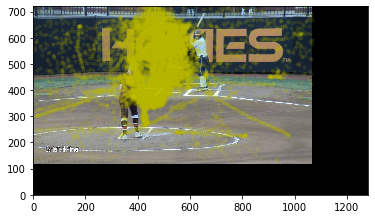

In [198]:
x = locations['cx']
y = abs(locations['cy'] - 720)
#y = locations['cy']

# load image as back
im = plt.imread('Average_spot.png')
im = np.flipud(im)
implot = plt.imshow(im, origin='lower')

# plot scatterplot over image
plt.scatter(x,y, marker = '.', alpha=0.1, color='y')
plt.xlim([0,1280])
plt.ylim([0,720])


"""
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(160,90))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()
"""

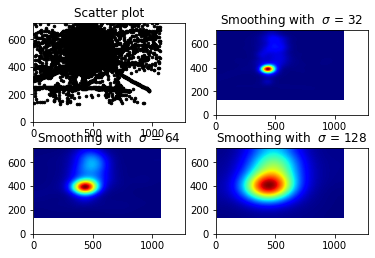

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

sigmas = [0, 32, 64, 128]

for ax, s in zip(axs.flatten(), sigmas):
    ax.set_xlim([0,1280])
    ax.set_ylim([0,720])
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)
    

plt.show()

In [102]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import scipy.ndimage.filters as filters


def plot(data, title, save_path):
    colors = [(0, 0, 1), (0, 1, 1), (0, 1, 0.75), (0, 1, 0), (0.75, 1, 0),
              (1, 1, 0), (1, 0.8, 0), (1, 0.7, 0), (1, 0, 0)]

    cm = LinearSegmentedColormap.from_list('sample', colors)

    plt.imshow(data, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.savefig(save_path)
    plt.close()


w = 640
h = 480

data = np.zeros(h * w)
data = data.reshape((h, w))

# Create a sharp square peak, just for example
for x in range(300, 340):
    for y in range(300, 340):
        data[x][y] = 100

# Smooth it to create a "blobby" look
#data = filters.gaussian_filter(data, sigma=15)

plot(data, 'Sample plot', 'sample.jpg')

## Pitch Location Algorithm

In [203]:
# Using the side angle as reference
side = pd.read_csv('Duke Game 1 3rd Base Dugout.csv')
center = pd.read_csv('Duke Game 1 Center Field.csv')
side['cx'] = (side['cx']*1280).astype(int)
side['cy'] = (side['cy']*720).astype(int)
side['w'] = (side['w']*1280).astype(int)
side['h'] = (side['h']*720).astype(int)

center['cx'] = (center['cx']*1280).astype(int)
center['cy'] = (center['cy']*720).astype(int)
center['w'] = (center['w']*1280).astype(int)
center['h'] = (center['h']*720).astype(int)


In [218]:
result = pd.merge(side, center, how='inner', on=['Frame'])
result.iloc[30:,:]

,Frame,cx_x,cy_x,w_x,h_x,cx_y,cy_y,w_y,h_y
30,993,572,149,24,23,884,64,22,21
31,994,416,88,34,34,855,33,24,23
32,1223,213,402,31,29,734,224,27,25
33,1224,551,414,35,35,751,220,25,24
34,1225,817,395,36,36,762,216,24,23
35,1226,1027,331,35,33,858,178,25,25
36,1227,1207,267,38,36,987,126,25,25
37,1227,1234,270,40,41,987,126,25,25
38,1528,616,466,37,32,805,243,24,23
39,1529,945,499,30,26,822,243,24,22


In [310]:
# get the 1st frame in which each stream was found
# Data frame to store rows that show the ball crossing the plate
df = pd.DataFrame(columns=result.columns)

last_frame = 0
i = 0
for index, row in result.iterrows():
    # Find the 1st instance 
    if abs(row['Frame'] - last_frame) > 200:
        df.loc[i] = result.loc[index + 1]
    last_frame = row['Frame']
    i += 1


In [313]:
#df = df.iloc[:,5:]
#df.columns = ['cx','cy','w','h']
df.drop([59])
df.to_csv("Pitch_Locations.csv")

In [314]:
df

,Frame,cx_x,cy_x,w_x,h_x,cx_y,cy_y,w_y,h_y
0,219,340,499,32,31,747,262,24,22
3,514,377,400,32,31,630,222,25,25
7,916,380,473,32,32,764,236,25,23
32,1224,551,414,35,35,751,220,25,24
38,1529,945,499,30,26,822,243,24,22
59,1862,477,548,31,30,701,303,25,22
77,2316,365,472,38,34,670,265,25,23
84,2770,946,485,31,28,835,233,24,23
91,3124,407,510,35,31,786,271,23,21
95,3547,1160,383,30,30,786,166,23,22


## Plotting the ball locations over an image

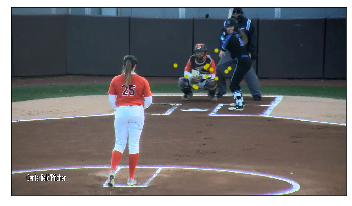

In [315]:
im = plt.imread('frames/frame00137_CENTER.jpg')
im = np.flipud(im)
implot = plt.imshow(im, origin='lower')

x = df['cx_y']
y = abs(df['cy_y'] - 720)
plt.scatter(x,y, marker = '.', color='y')
plt.xlim([0,1280])
plt.ylim([0,720])
plt.xticks([])
plt.yticks([])

plt.savefig("Pitch_Locations.png", dpi =320)


In [266]:
side

,Frame,cx,cy,w,h
0,25,927,257,20,21
1,26,917,241,19,20
2,27,924,243,19,20
3,28,927,243,19,19
4,29,917,231,18,19
5,30,917,234,19,20
6,31,912,235,18,19
7,33,905,238,17,18
8,34,904,244,18,19
9,217,15,474,27,29


## Label Side View

In [298]:
side1 = side.loc[9]
side2 = side.loc[10]

img = cv2.imread('frames/frame00219_SIDE.jpg')
# obtain the mean x,y,width, and height values
cx = side1['cx']
cy = side1['cy']
width = side1['w']
height = side1['h']
# image dimensions: (720, 1280)

# top left and right of the average rectangle
start = (int(cx - (width / 2)), int(cy - (height / 2)))
end = (int(cx + (width / 2)), int(cy + (height / 2)))
# draw avg rectangle over image and save it
img = cv2.rectangle(img, start, end, (0, 0, 255) , 2)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (cx -15 ,cy - int(height/2) -3)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

img = cv2.putText(img,'Ball', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

img = img[150:,:900]

cv2.imwrite("Side1.png", img)

True

In [309]:
side1 = side.loc[9]
side2 = side.loc[10]

img = cv2.imread('frames/frame00220_SIDE.jpg')
# obtain the mean x,y,width, and height values
cx = side2['cx']
cy = side2['cy']
width = side2['w']
height = side2['h']
# image dimensions: (720, 1280)

# top left and right of the average rectangle
start = (int(cx - (width / 2)), int(cy - (height / 2)))
end = (int(cx + (width / 2)), int(cy + (height / 2)))
# draw avg rectangle over image and save it
img = cv2.rectangle(img, start, end, (0, 0, 255) , 4)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (cx -15 ,cy - int(height/2) -3)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

img = cv2.putText(img,'Ball', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

img = img[150:,:900]


cv2.imwrite("Side2.png", img)

True

In [308]:
center1 = center.loc[32]
center2 = center.loc[33]

img = cv2.imread('frames/frame00219_CENTER.jpg')
# obtain the mean x,y,width, and height values
cx = center1['cx']
cy = center1['cy']
width = center1['w']
height = center1['h']
# image dimensions: (720, 1280)

# top left and right of the average rectangle
start = (int(cx - (width / 2)), int(cy - (height / 2)))
end = (int(cx + (width / 2)), int(cy + (height / 2)))
# draw avg rectangle over image and save it
img = cv2.rectangle(img, start, end, (0, 0, 255) , 2)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (cx -15 ,cy - int(height/2) -3)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

img = cv2.putText(img,'Ball', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

img = img[50:620,190:1090]

cv2.imwrite("center1.png", img)

True

In [307]:
center1 = center.loc[32]
center2 = center.loc[33]

img = cv2.imread('frames/frame00220_CENTER.jpg')
# obtain the mean x,y,width, and height values
cx = center2['cx']
cy = center2['cy']
width = center2['w']
height = center2['h']
# image dimensions: (720, 1280)

# top left and right of the average rectangle
start = (int(cx - (width / 2)), int(cy - (height / 2)))
end = (int(cx + (width / 2)), int(cy + (height / 2)))
# draw avg rectangle over image and save it
img = cv2.rectangle(img, start, end, (0, 0, 255) , 2)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (cx -15 ,cy - int(height/2) -3)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

img = cv2.putText(img,'Ball', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

img = img[50:620,190:1090]

cv2.imwrite("center2.png", img)

True

In [306]:
1280-190

1090